<a href="https://colab.research.google.com/github/Jack3690/INSIST_pipeline/blob/main/notebooks/MACADAMIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install insist-pista --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.0/857.0 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 83.5 MB/s eta 0:00:00


In [ ]:
!pip install astrometry --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.7 MB/s eta 0:00:00


In [ ]:
!pip install astroquery --quiet
!pip install reproject --quiet
!pip install photutils --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 kB 33.6 MB/s eta 0:00:00


In [ ]:
from astroquery.astrometry_net import AstrometryNet

In [2]:
import pista as pt
import numpy as np
import os
import matplotlib.pyplot as plt

import matplotlib.colors as col
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.nddata import CCDData
import astropy.units as u
import astropy.stats as stats

from astropy.modeling import models, fitting

import photutils as phot
from photutils.detection import DAOStarFinder

from reproject import reproject_interp, reproject_exact
from astropy.convolution import Gaussian2DKernel, convolve_fft
from photutils.segmentation import detect_sources, deblend_sources, SourceCatalog

In [5]:
data_path = pt.data_dir

In [ ]:
!git clone https://github.com/Jack3690/INSIST_pipeline --quiet

# **Image Generation using PISTA**

In [6]:
if not os.path.exists('input_data'):
  os.mkdir('input_data')

In [7]:
# Example using FITS table
tab = Table.read(f'{data_path}/sample.fits')  # FITS Table
df  = tab.to_pandas()             # PISTA requires pandas DataFrame

In [8]:
tel_params = {
              'aperture'       : 100,
              'pixel_scale'    : 0.1,
              'psf_file'       : f'{data_path}/PSF/INSIST/off_axis_hcipy.npy',
              'response_funcs' :  [ f'{data_path}/INSIST/UV/Filter.dat,1,100',
                                    f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 5 mirrors
                                    f'{data_path}/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                  ],
              }

det_params = {    'shot_noise' :  'Gaussian',
                  'G1'         :  1,
                  'PRNU_frac'  :  0.25/100,
                  'qe_response': [f'{data_path}/INSIST/UV/QE.dat,1,100'],
                  'RN'         :  5,
                  'T'          :  218,
                  'DCNU'       :  0.1/100
             }

In [9]:
sim = pt.Imager(df = df,tel_params = tel_params, n_x = 500, n_y = 500,
                exp_time = 2400)

user_profiles = {'PRNU' : sim.flat_frame,
                 'Bias' : sim.bias_array,
                 'DNFP' : sim.DNFP_array}

sim(det_params = det_params, photometry = None)

flats = []
biass = []
darks = []

ts = []
for i, t in enumerate([2400, 2400, 2400, 2400]):

  del_ra = np.random.random(1)[0]/3600
  del_dec = np.random.random(1)[0]/3600

  coords = (11.0689964234, 41.3520244153)

  sim = pt.Imager(df = df, coords = coords,
                  tel_params = tel_params, n_x = 500, n_y = 500,
                  exp_time = t, user_profiles = user_profiles)
  sim( det_params = det_params, photometry = 'Aper')

  sim.writeto(f'input_data/img{i}.fits')

  flat = sim.flat_frame

  exp_time = sim.exp_time
  sim.exp_time=1
  bias = sim.make_ccd_image(0)
  sim.exp_time = exp_time

  dark = sim.dark_frame

  flats.append(flat)
  biass.append(bias)
  darks.append(dark)
  ts.append(sim.exp_time)

/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


## **Calibration Database creation**

In [10]:
flats = np.array(flats)
biass = np.array(biass)
darks = np.array(darks)
ts    = np.array(ts).reshape(-1,1,1)

In [11]:
master_flat = np.median(flats, axis = 0)
master_bias = np.median(biass, axis = 0)
master_dark = np.median((darks - master_bias)/ts, axis = 0)

In [12]:
header = sim.header

In [13]:
header['FRAME'] = 'MASTER FLAT'
hdu = fits.PrimaryHDU(master_flat, header=header)
hdul = fits.HDUList([hdu])
hdul.writeto('/content/INSIST_pipeline/data/Cal_DB/Master_Flat.fits'
              , overwrite=True)

header['FRAME'] = 'MASTER BIAS'
hdu = fits.PrimaryHDU(master_bias, header=header)
hdul = fits.HDUList([hdu])
hdul.writeto('/content/INSIST_pipeline/data/Cal_DB/Master_Bias.fits'
              , overwrite=True)

header['FRAME'] = 'MASTER DARK'
hdu = fits.PrimaryHDU(np.abs(master_dark), header=header)
hdul = fits.HDUList([hdu])
hdul.writeto('/content/INSIST_pipeline/data/Cal_DB/Master_Dark.fits'
              , overwrite=True)

# **Pipeline**

## **Calibration**

In [14]:
input_dir = '/content/input_data'
cal_db = '/content/INSIST_pipeline/data/Cal_DB'

dark = fits.open(f'{cal_db}/Master_Dark.fits')[0].data
bias = fits.open(f'{cal_db}/Master_Bias.fits')[0].data
flat = fits.open(f'{cal_db}/Master_Flat.fits')[0].data

out_dir = 'Out_FC'
if not os.path.exists(out_dir):
  os.mkdir(out_dir)
for f in os.listdir(input_dir):

  hdul = fits.open(f'{input_dir}/{f}')
  data = hdul[0].data

  # Dark and Bias Subtraction

  dark_e = dark*hdul[0].header['EXPTIME']
  data_DB = data - bias - dark_e

  # Flat fielding
  data_F = data_DB/flat

  hdul[0].data = data_F
  hdul[0].header['FRAME'] = "FLUX CALIBRATED"
  hdul[0].header['BUNIT'] ='CPS'
  hdul[0].header['ZP'] = 22.239
  hdul.writeto(f"{out_dir}/{f.split('.')[0]}_FC.fits", overwrite = True)

In [15]:
(sim.digital.shape[0]*0.1)/3600

0.013888888888888888

## **Pre-processing**

## **Astrometric Calibration (Curvit)**

In [18]:
WCS.

AttributeError: ignored

In [ ]:
import astrometry as at

In [ ]:
!rm -r astrometry_cache

In [ ]:
solver = at.Solver(at.series_5200.index_files(
        cache_directory="astrometry_cache",
        scales={6} ))

In [ ]:
data = hdul[0].data
wcs = WCS(hdul[0].header)
sigma = 3.0*stats.gaussian_fwhm_to_sigma  # FWHM = 3.

kernel = Gaussian2DKernel(x_stddev=sigma)

# Define DAOStarFinder parameters
threshold = 5.0  # Detection threshold
fwhm = 3.0      # Full Width at Half Maximum (approximate stellar size)

# Perform star detection/multimedia/nasatv/index.html
daofind = DAOStarFinder(threshold, fwhm, exclude_border=True)
mean, _, std = stats.sigma_clipped_stats(data, sigma=5.0, maxiters=1)

convolved_data = convolve_fft(data,kernel)
sources = daofind(convolved_data-mean)
sources.sort("mag")

stars = np.array([sim.img_df['x'], sim.img_df['y']]).T
stars = np.round(stars, 2)

solution = solver.solve(
    stars=stars,
    size_hint=None,
    position_hint= at.PositionHint(
        ra_deg=11.0689964234,
        dec_deg=41.3520244153,
        radius_deg=0.0138),
    solution_parameters=at.SolutionParameters(),
)

In [ ]:
ast.

In [ ]:
hdul[0].header["NAXIS1"]

500

In [ ]:
ast.show_allowed_settings()

allow_commercial_use: type 'str', default value d, allowed values ('d', 'y', 'n')
allow_modifications: type 'str', default value d, allowed values ('d', 'y', 'n')
center_dec: type 'float', default value None, allowed values (-90, 90)
center_ra: type 'float', default value None, allowed values (0, 360)
crpix_center: type 'bool', default value None, allowed values ()
downsample_factor: type 'int', default value None, allowed values (1,)
parity: type 'int', default value None, allowed values (0, 2)
positional_error: type 'float', default value None, allowed values (0,)
publicly_visible: type 'str', default value y, allowed values ('y', 'n')
radius: type 'float', default value None, allowed values (0,)
scale_err: type 'float', default value None, allowed values (0, 100)
scale_est: type 'float', default value None, allowed values (0,)
scale_lower: type 'float', default value None, allowed values (0,)
scale_type: type 'str', default value None, allowed values ('ev', 'ul')
scale_units: type '

## **Combining Images**

In [25]:
def align_fits_images(fits_files, out_shape=(512,512)):
    # Open the first FITS file to get the reference image
    reference_hdulist = fits.open(fits_files[0])
    wcs = WCS(reference_hdulist[0].header)
    reference_image = reference_hdulist[0]
    reference_wcs = WCS(reference_hdulist[0].header)

    # Create an array to store the aligned images
    aligned_images = []

    # Loop through the remaining FITS files
    for fits_file in fits_files:
        # Open the FITS file and read the image data
        hdulist = fits.open(fits_file)
        image = hdulist[0]

            # Reproject the image to match the reference image
        aligned_image, _ = reproject_exact(image,reference_wcs,
                                           out_shape)

        # Add the aligned image to the list
        aligned_images.append(aligned_image)

        # Close the FITS file
        hdulist.close()


    return np.array(aligned_images).mean(axis=0)

In [26]:
out_dir = 'Out_FC'

sources = [ out_dir + '/' + i for i in os.listdir(out_dir)]

aligned_images = align_fits_images(sources)

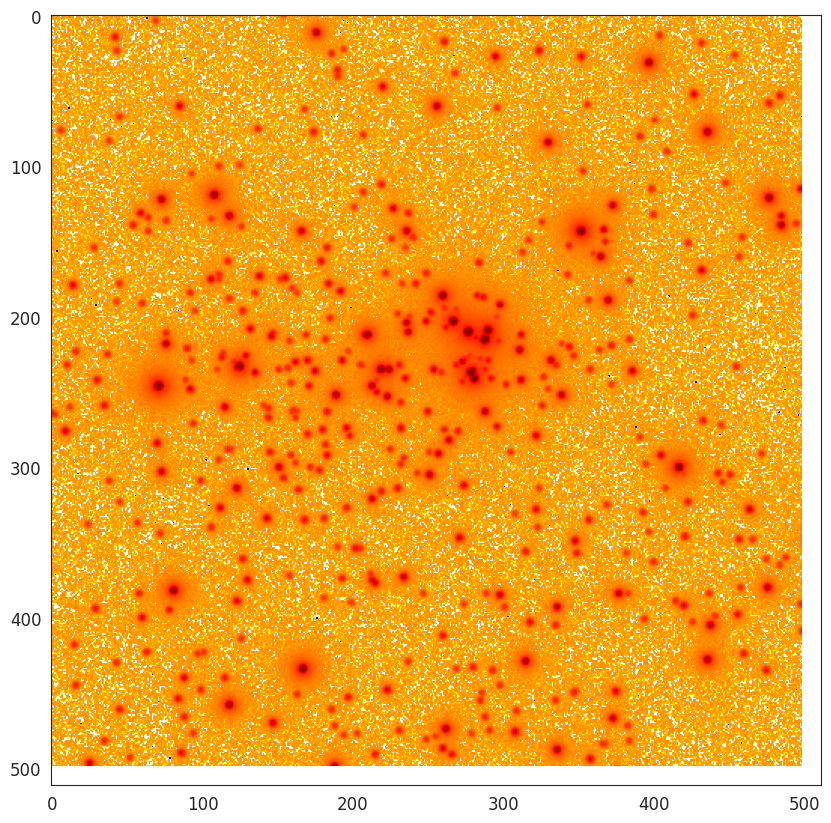

In [28]:
plt.imshow(aligned_images, cmap='jet', norm = col.LogNorm())

(<Figure size 1500x1000 with 2 Axes>,
 <WCSAxes: title={'center': 'Digital \nRequested center :  RA : 11.069 degrees, Dec : 41.352 degrees'}>)

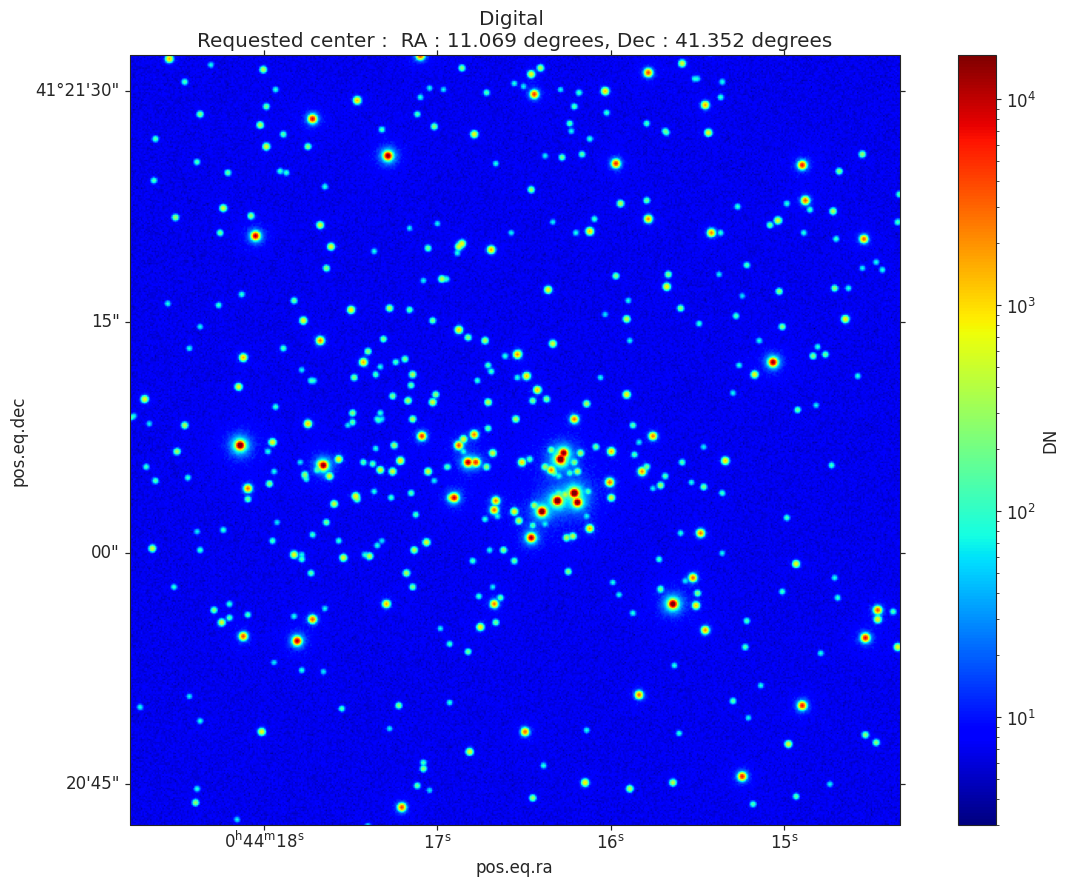

In [29]:
sim.show_image()